# Multisensor image classification

## Introduction
Using images from different sensors (e.g. SAR and multi-spectral together) provides different information to a classifier, sometimes resulting in a better classification results.   

In this lab, we will use the example of a glacial lake in the Yukon to practice using Random Forest classification, using both, or one of Sentinel 1 (SAR) and Sentinel 2 (MSI).

The Donjek Glacier had a glacial lake form at its terminus. But in July 2019, the ice jam holding back the water burst and the lake disappeared.  Read this article before starting the lab [here](https:#www.cbc.ca/news/canada/north/glacial-lake-bursts-in-yukon-1.5312116)

We will use a similar (but simplified) version of the analysis found [here.](https:#www.sciencedirect.com/science/article/pii/S2666017220300079#bib46)




## Imports, Authentication & Initialization
First and foremost, set up the notebook and import the appropriate libraries, as we have done in previous labs.

Set up a few useful functions and mount your drive.

In [82]:
# Let's setup our script first
!pip install geopandas
!pip install pycrs

import ee
import geemap as geemap
import numpy as np
import pandas as pd
import geopandas as geopandas
import json
import pycrs

import plotnine
from plotnine import *
import matplotlib.pyplot as plt

ee.Authenticate()
ee.Initialize(project='ee-cptcitrus-main')

In [4]:
# This function prints image bands in an easily readable format
def printImageBands(image):
  print('Bands of example image:')
  for band in range(len(image['bands'])):
    print(image['bands'][band]['id'])
  print('\n')

def printImageNames(collection):
  print('All images in image collection:')
  for img in range(len(collection['features'])):
    print(str(img) + ': ' + collection['features'][img]['id'])
  print('\n')

In [5]:
# Mount your google drive
# from google.colab import drive
# drive.mount('/content/drive')

## Locate, Import, and Process Imagery
In this example, we will be looking at a region that experiences a lot of cloud resulting in spotty multi-spectral image coverage.  In regions such as this, it is common to draw on multiple sensors (Sentinel 1 and Sentinel-2), then stack the imagery together to facilitate the image classification.

The area is full of interesting glaciers that can both form and drain lakes suddenly, which is of interest to geomorphologists and hazards prediction folks alike. Here, we want to combine data from two different sensors to see if we can detect a pro-glacial lake at the terminus of the Donjek Glacier that we know formed in early 2019 and then drained later that season.

The Donjek Glacier is uncommon as it falls into a category of glaciers that can remain near stationary for a decade and suddenly surge in a short timespan down the valley. The latest surge in 2014 caused the formation of this lake. The lake typically releases and drains into the valley in August at a more gradual rate. In 2019, the glacial lake drained completely in about 36 hours!

Our "least cloudy" Sentinel-2 image is still plagued with cloud and cloud shadow, we are going to use an advanced method of cloud masking.  To learn more about this technique see [this page](https:#developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless) and related Notebook.  

The values currently set for `AOI`, `START_DATE`, `END_DATE`, and `CLOUD_FILTER` are intended to build a collection for a single S2 overpass of the Donjek Glacier.

In [6]:
Donjek_AOI = 'C:/Users/cptci/OneDrive - Carleton University/Documents/GitHub/GEOG6006-qb/GEOG6006-qb/data/donjek_AOI/donjek_AOI/Donjek_AOI.shp' # This will have to be changed for a lab scenario
AOI = geemap.shp_to_ee(Donjek_AOI)

#Create a point (mid-glacier) to aid in our mapping and filtering activities
donjek_gl = ee.Geometry.Point(-139.70117,61.070340)

#based on trial and error, we know that an image with low cloud cover is available during this time period.
START_DATE = '2019-06-24'
END_DATE = '2019-07-01'
CLOUD_FILTER = 60
CLD_PRB_THRESH = 50
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50

### Build a Sentinel-2 Collection

[Sentinel-2 surface reflectance](https:#developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR) and [Sentinel-2 cloud probability](https:#developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_CLOUD_PROBABILITY) are two different image collections. Each collection must be filtered similarly (e.g., by date and bounds) and then the two filtered collections must be joined.

Define a function to filter the 'SR' and 's2cloudless' collections according to area of interest and date parameters, then join them on the `system:index` property. The result is a copy of the 'SR' collection where each image has a new `'s2cloudless'` property whose value is the corresponding 's2cloudless' image.

In [15]:
def get_s2_sr_cld_col(AOI, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(AOI)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(AOI)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

Apply the `get_s2_sr_cld_col` function to build a collection according to the parameters defined above.

In [16]:
s2_sr_cld_col_eval = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)

### Define Cloud Mask Component Functions

#### Cloud components

Define a function to add the 's2cloudless' probability layer and derived cloud mask as bands to an S-2 SR image input.

In [17]:
def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

#### Cloud shadow components

Define a function to add dark pixels, cloud projection, and identified shadows as bands to an S-2 SR image input. Note that the image input needs to be the result of the above `add_cloud_bands` function because it relies on knowing which pixels are considered cloudy (`'clouds'` band).

In [18]:
def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

#### Final cloud-shadow mask

Define a function to assemble all of the cloud and cloud shadow components and produce the final mask.

In [19]:
def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

### Define Cloud Mask Application Function

Define a function to apply the cloud mask to each image in the collection.

In [20]:
def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

### Process the Collection

Add cloud and cloud shadow component bands to each image and then apply the mask to each image. Reduce the collection by median (in your application, you might consider using medoid reduction to build a composite from actual data values, instead of per-band statistics).

In [21]:
# we are going to create two datasets - one that contains the cloud and cloud shadow bands, and one with the clouds and cloud shadows masked.

#we will use this dataset to display the cloud masks to see if we have removed enough cloud/cloud shadow
S2_withMasks = s2_sr_cld_col_eval.map(add_cld_shdw_mask).mosaic() #we use the mosaic function here because we actuall have two images that are part of the same swath (taking moments apart) this converts them to a single "image"

# we will use the "masked" dataset created below for further analysis
S2_masked = s2_sr_cld_col_eval.map(add_cld_shdw_mask).map(apply_cld_shdw_mask).mosaic()

print("masked bands")
printImageBands(S2_masked.getInfo())

print('all bands')
printImageBands(S2_withMasks.getInfo())

masked bands
Bands of example image:
B1
B2
B3
B4
B5
B6
B7
B8
B8A
B9
B11
B12


all bands
Bands of example image:
B1
B2
B3
B4
B5
B6
B7
B8
B8A
B9
B11
B12
AOT
WVP
SCL
TCI_R
TCI_G
TCI_B
MSK_CLDPRB
MSK_SNWPRB
QA10
QA20
QA60
MSK_CLASSI_OPAQUE
MSK_CLASSI_CIRRUS
MSK_CLASSI_SNOW_ICE
probability
clouds
dark_pixels
cloud_transform
shadows
cloudmask




In [24]:
# Let's visualize the cloud and cloud shadow.
# for this we need to use the "withMasks" image
clouds = S2_withMasks.select('clouds').selfMask()
shadows =  S2_withMasks.select('shadows').selfMask()

cloud_vis = {'palette': 'orange'}
shadow_vis = {'palette': 'purple'}

Map = geemap.Map()

Map.addLayer(clouds,  cloud_vis, "clouds")
Map.addLayer(shadows, shadow_vis, "cloud shadow")
Map.centerObject(donjek_gl,12)

Map


Map(center=[61.07034, -139.70117], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

It looks like we've done a pretty good job removing cloud and cloud shadow.  Let's proceed!

### Build a Sentinel-1 Collection

Let's now grab some Sentinel-1 (SAR) data to support our goal of using multiple sensors to classify the area. We should obtain S-1 imagery from approximately the same time period as our S-2 image.

In [25]:
# Gather data from Sentinel 1 for the AOI
# We are just using the 2019 image because that is the year we are interested in
S1_june =  ee.ImageCollection('COPERNICUS/S1_GRD') \
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
.filter(ee.Filter.eq('instrumentMode', 'IW')) \
.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')) \
.filterBounds(AOI) \
.filterDate('2019-06-24','2019-07-01')


In [26]:
printImageNames(S1_june.getInfo())

All images in image collection:
0: COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDV_20190625T154803_20190625T154828_027838_03248D_9C54
1: COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDV_20190625T154828_20190625T154853_027838_03248D_A2C2




There are two SAR images that adequately match our temporal, spatial, and technical filters. If you look at the image dates, you can see that (like the S-2 data) they are split images from the same swath. We'll apply a speckle filter on these images and then mosaic them into a single image so we can use them for classification.

In [27]:
S1_june_m = S1_june.mosaic()

#### Applying a Lee Filter Function

We will apply a Lee filter to our data to filter out SAR speckle. You can find more information on speckle filtering [here.](https:#www.researchgate.net/publication/239659062_Speckle_filtering_of_synthetic_aperture_radar_images_A_Review) For the purposes of our lab, the speckle filter may provide better results during classification. It typically will reduce the amount of impact speckle has on SAR imagery.

In [32]:
#function for the Lee Filter
def toNatural(img):
    return ee.Image(10.0).pow(img.select(0).divide(10.0))

#Function to convert to dB
def toDB(img):
    return ee.Image(img).log10().multiply(10.0)
def RefinedLee(img):
    # img must be in natural units, i.e. not in dB!
    # Set up 3x3 kernels

    # convert to natural.. do not apply function on dB!
    # our images are in dB so we need to apply the toNatural algorithm
    myimg = toNatural(img)

    weights3 = ee.List.repeat(ee.List.repeat(1,3),3)  #this sets all pixels in window to weight of 1
    kernel3 = ee.Kernel.fixed(3,3, weights3, 1, 1, False) #this creates a 3x3 window

    mean3 = myimg.reduceNeighborhood(ee.Reducer.mean(), kernel3) #this smooths the image using a 3x3 window and calculating the mean for those pixels
    variance3 = myimg.reduceNeighborhood(ee.Reducer.variance(), kernel3) #this calculates the variance of each pixel in a 3x3 window - will highlight edges/texture

    # Use a sample of the 3x3 windows inside a 7x7 windows to determine gradients and directions
    sample_weights = ee.List([[0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0], [0,1,0,1,0,1,0], [0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0]])

    sample_kernel = ee.Kernel.fixed(7,7, sample_weights, 3,3, False)

    # Calculate mean and variance for the sampled windows and store as 9 bands
    sample_mean = mean3.neighborhoodToBands(sample_kernel)
    sample_var = variance3.neighborhoodToBands(sample_kernel)

    # Determine the 4 gradients for the sampled windows
    gradients = sample_mean.select(1).subtract(sample_mean.select(7)).abs()
    gradients = gradients.addBands(sample_mean.select(6).subtract(sample_mean.select(2)).abs())
    gradients = gradients.addBands(sample_mean.select(3).subtract(sample_mean.select(5)).abs())
    gradients = gradients.addBands(sample_mean.select(0).subtract(sample_mean.select(8)).abs())

    # And find the maximum gradient amongst gradient bands
    max_gradient = gradients.reduce(ee.Reducer.max())

    # Create a mask for band pixels that are the maximum gradient
    gradmask = gradients.eq(max_gradient)

    # duplicate gradmask bands: each gradient represents 2 directions
    gradmask = gradmask.addBands(gradmask)

    # Determine the 8 directions
    directions = sample_mean.select(1).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(7))).multiply(1)
    directions = directions.addBands(sample_mean.select(6).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(2))).multiply(2))
    directions = directions.addBands(sample_mean.select(3).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(5))).multiply(3))
    directions = directions.addBands(sample_mean.select(0).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(8))).multiply(4))
    # The next 4 are the not() of the previous 4
    directions = directions.addBands(directions.select(0).Not().multiply(5))
    directions = directions.addBands(directions.select(1).Not().multiply(6))
    directions = directions.addBands(directions.select(2).Not().multiply(7))
    directions = directions.addBands(directions.select(3).Not().multiply(8))

    # Mask all values that are not 1-8
    directions = directions.updateMask(gradmask)

    # "collapse" the stack into a singe band image (due to masking, each pixel has just one value (1-8) in it's directional band, and is otherwise masked)
    directions = directions.reduce(ee.Reducer.sum())

    sample_stats = sample_var.divide(sample_mean.multiply(sample_mean))

    # Calculate localNoiseVariance
    sigmaV = sample_stats.toArray().arraySort().arraySlice(0,0,5).arrayReduce(ee.Reducer.mean(), [0])

    # Set up the 7*7 kernels for directional statistics
    rect_weights = ee.List.repeat(ee.List.repeat(0,7),3).cat(ee.List.repeat(ee.List.repeat(1,7),4))

    diag_weights = ee.List([[1,0,0,0,0,0,0], [1,1,0,0,0,0,0], [1,1,1,0,0,0,0],
                            [1,1,1,1,0,0,0], [1,1,1,1,1,0,0], [1,1,1,1,1,1,0], [1,1,1,1,1,1,1]])

    rect_kernel = ee.Kernel.fixed(7,7, rect_weights, 3, 3, False)
    diag_kernel = ee.Kernel.fixed(7,7, diag_weights, 3, 3, False)

    # Create stacks for mean and variance using the original kernels. Mask with relevant direction.
    dir_mean = myimg.reduceNeighborhood(ee.Reducer.mean(), rect_kernel).updateMask(directions.eq(1))
    dir_var = myimg.reduceNeighborhood(ee.Reducer.variance(), rect_kernel).updateMask(directions.eq(1))

    dir_mean = dir_mean.addBands(myimg.reduceNeighborhood(ee.Reducer.mean(), diag_kernel).updateMask(directions.eq(2)))
    dir_var= dir_var.addBands(myimg.reduceNeighborhood(ee.Reducer.variance(), diag_kernel).updateMask(directions.eq(2)))

    # and add the bands for rotated kernels
    for i in range(1,4):
        dir_mean = dir_mean.addBands(myimg.reduceNeighborhood(ee.Reducer.mean(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
        dir_var = dir_var.addBands(myimg.reduceNeighborhood(ee.Reducer.variance(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
        dir_mean = dir_mean.addBands(myimg.reduceNeighborhood(ee.Reducer.mean(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))
        dir_var = dir_var.addBands(myimg.reduceNeighborhood(ee.Reducer.variance(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))

    # "collapse" the stack into a single band image (due to masking, each pixel has just one value in it's directional band, and is otherwise masked)
    dir_mean = dir_mean.reduce(ee.Reducer.sum())
    dir_var= dir_var.reduce(ee.Reducer.sum())

    # A finally generate the filtered value
    varX = dir_var.subtract(dir_mean.multiply(dir_mean).multiply(sigmaV)).divide(sigmaV.add(1.0))

    b = varX.divide(dir_var)

    result = dir_mean.add(b.multiply(myimg.subtract(dir_mean)))
    #return(result)
    return(img.addBands(ee.Image(toDB(result.arrayGet(0))).rename("filter")))
    #end of function

In [33]:
#apply to Lee Filter to both VV and VH bands
s1_LeeVV = S1_june.select('VV').map(RefinedLee).select(['filter'], ['VV'])  #we will rename the the filtered bands to VV and VH
s1_LeeVH = S1_june.select('VH').map(RefinedLee).select(['filter'], ['VH'])

We want both images to capture all of our study area polygon.  If you look at the system:index information you can see that these images are actually from the same swath, just split for data storage purposes (e.g. the orbit information is the same, and taken seconds apart).  

Therefore, we will mosaick these two images together.  

In [34]:
#then mosaic each of the VV and VH images, then add them together into one final stack.
S1_juneVV_mosaic = s1_LeeVV.mosaic()
S1_juneVH_mosaic = s1_LeeVH.mosaic()

S1_june_mosaic = S1_juneVV_mosaic.addBands(S1_juneVH_mosaic)

In [35]:
#Let's map it to ensure we know what we have
Map = geemap.Map()
shpdata_vis = {
    'color': '#37c5db',
    'width': 2,
    'lineType': 'solid',
    'fillColor': '00000000', #no fill on polygons
}

S1_vis = {
  'bands': ['VV', 'VH', 'VV'],
  'min': [-25, -25, -25],
  'max':  [1, 1, 1]
}

Map.addLayer(S1_june_mosaic,S1_vis,'mosaic')
Map.addLayer(AOI.style(**shpdata_vis), {}, "Donjek_AOI")

Map.addLayerControl()
Map.centerObject(donjek_gl, 9)

Map

Map(center=[61.07034, -139.70117], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

There seems to be a missing strip derived from applying the Speckle filer, but this should not affect our overall results.

In [36]:
# we will also calculate the VV/VH ratio and add that to the mosaic
VVVH = (S1_june_mosaic.select('VV')).divide(S1_june_mosaic.select('VH')).rename("VVVH")
S1_june_mosaic = S1_june_mosaic.addBands(VVVH)

# Let's double check what bands are in this image
printImageBands(S1_june_mosaic.getInfo())

Bands of example image:
VV
VH
VVVH




In [37]:
#Let's map it to ensure we know what we have
Map = geemap.Map()

shpdata_vis = {
    'color': '#37c5db',
    'width': 2,
    'lineType': 'solid',
    'fillColor': '00000000', #no fill on polygons
}

S1_vis2 = {
  'bands': ['VV', 'VH', 'VVVH'],
  'min': [-25, -25, 0],
  'max':  [1, 1, 1]
}

Map.addLayer(S1_june_mosaic,S1_vis2,'S1')
Map.addLayer(AOI.style(**shpdata_vis), {}, "Donjek_AOI")

Map.addLayerControl()
Map.centerObject(donjek_gl, 9)

Map

Map(center=[61.07034, -139.70117], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

### Additional Information

We will also use some elevation data in our classifications.  Let's bring in the CDEM data and calcualte slope, then add it to our stack.  

In [38]:
#add slope and DEM as variable
#Arctic DEM
dem = ee.ImageCollection('NRCan/CDEM')
elevation = dem.select('elevation').mosaic()

#calculate slope for canada based on NRCan DEM
slope = ee.Terrain.slope(elevation)

# and add them as bands S2 PreImage
Stack1 = S2_masked.addBands(elevation).addBands(slope).addBands(S1_june_mosaic)
band_names1 = Stack1.bandNames()
# Let's double check what bands are in this image
print(band_names1.getInfo())

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'elevation', 'slope', 'VV', 'VH', 'VVVH']


In [39]:
#Let's map it to ensure we know what we have
Map = geemap.Map()

shpdata_vis = {
    'color': '#37c5db',
    'width': 2,
    'lineType': 'solid',
    'fillColor': '00000000', #no fill on polygons
}

S1_vis2 = {
  'bands': ['VV', 'VH', 'VVVH'],
  'min': [-25, -25, 0],
  'max':  [1, 1, 1]
}

S2_vis = {
  'bands': ['B4', 'B3', 'B4'],
  'min': 0,
  'max': 3000,
  'gamma': 1.4,
}

Map.addLayer(Stack1,S1_vis2,'S1_PreImage')
Map.addLayer(Stack1,S2_vis,'S2_PreImage')
Map.addLayer(AOI.style(**shpdata_vis), {}, "Donjek_AOI")

Map.addLayerControl()
Map.centerObject(donjek_gl, 9)

Map

Map(center=[61.07034, -139.70117], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

Let's also calculate the Normalised Difference Water Index (Wangchuk and Bolch, 2020) to help in the detection of glacial lakes in mountainous areas. We do this using the blue, green and NIR bands of S-2 images:

NDWI*blue* = (Blue - NIR) / (Blue - NIR)

NDWI*green* = (Green - NIR) / (Green - NIR)

**Note:** the full script is much more complicated, we are doing a simple version for demonstration purposes.

In [40]:
# create a band that calculates the NDWI for blue and add it to the S2 mosaic
NDWIblue = (Stack1.select('B2').subtract(Stack1.select('B8'))).divide(Stack1.select('B2')).add(Stack1.select('B8')).rename("NDWIb")
Stack1 = Stack1.addBands(NDWIblue)

# do the same for green
NDWIgreen = (Stack1.select('B3').subtract(Stack1.select('B8'))).divide(Stack1.select('B3')).add(Stack1.select('B8')).rename("NDWIg")
Stack1 = Stack1.addBands(NDWIgreen)

# and let's do NDVI as well
NDVI =(Stack1.normalizedDifference(['B8','B4'])).rename("ndvi")
Stack1 = Stack1.addBands(NDVI)

In [41]:
# Let's double check what bands are in this image
all_band_names = Stack1.bandNames()
print(all_band_names.getInfo())
#we will store this as a variable so we can use it later.

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'elevation', 'slope', 'VV', 'VH', 'VVVH', 'NDWIb', 'NDWIg', 'ndvi']


## Set up a Supervised, Multi-Sensor Classification using Random Forest
Remember from previous labs, where we introduced supervised and unsupervised classifications.

Here, we know what the classes are and have training data, so we will use a supervised classification, using similar code.

**Class 1:** ice/snow

**Class 2:** land

**Class 3:** water

Training data is provided to you.  It was collected using Planet imagery from May 2019.

In [101]:
data ="C:/Users/cptci/OneDrive - Carleton University/Documents/GitHub/GEOG6006-qb/GEOG6006-qb/data/donjek_training2/donjek2/donjek_training2_gcs.shp" # This path will have to be changed to match the location of your training data


# These points are known to be water and ice
points = geemap.shp_to_ee(data)

In [44]:
Map = geemap.Map()

# Training point visualzation parameters
vis_params = {
    'color': '000000',
    'colorOpacity': 1,
    'pointSize': 3,
    'pointShape': 'circle',
    'width': 0.5,
    'lineType': 'solid',
    'fillColorOpacity': 1
}
shpdata_vis = {
    'color': '#37c5db',
    'width': 2,
    'lineType': 'solid',
    'fillColor': '00000000', #no fill on polygons
}


# Colour pallette for the training data points
palette = ['D6E51B', 'FF0000', '000000']  # We have 3 classes so we need 3 colours in our pallette

Map.addLayer(Stack1,S2_vis,'S2')
Map.addLayer(Stack1,S1_vis2,'S1')
Map.addLayer(points, {}, "training")
Map.addLayer(AOI, shpdata_vis, "AOI")

Map.add_styled_vector(points, column="Class", palette=palette, layer_name="Donjek Training Points", **vis_params)  # ClassID is the field that we are using to colour our points

Map.addLayerControl()
Map.centerObject(donjek_gl, 12)

Map

Map(center=[61.07034, -139.70117], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

In order to use this data to train a classifier, we need to **extract the values** of the spatially coincident pixels for each band in our image. We will use the sampleRegions function, as seen in previous labs.

We will also convert the features/images we have into pandas dataframes, so we can perform analysis.

In [45]:
label = 'Class'  #this is the name of the field in our training data that tells us what the class should be at this location
# we are going to extract data from all of the bands, using the variable all_band_names that we created above

# Extract pixel values to training data points
training = Stack1.select(all_band_names).sampleRegions(
  collection = points,
  properties = [label],
  scale = 10
)

# convert our ee features to a pandas data frame
df = geemap.ee_to_df(training)
df.head() #the head function just displays the first few records

,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,...,B9,Class,NDWIb,NDWIg,VH,VV,VVVH,elevation,ndvi,slope
0,4578,40,55,4427,4336,3852,3729,3135,2710,2366,...,2182,1,2366.465576,2366.454346,-17.301305,-12.366019,0.714745,2103,-0.238984,0.247646
1,4273,52,58,4813,5088,4429,4063,3646,3081,2979,...,2605,1,2979.381104,2979.414551,-23.892054,-12.859356,0.538227,1969,-0.195734,0.247646
2,5032,68,66,5680,5410,4644,4612,3944,3245,2865,...,2646,1,2865.495605,2865.470459,-18.057674,-2.746223,0.152081,1824,-0.236916,0.247646
3,5075,75,76,4280,4112,3752,3637,3175,2790,2403,...,2777,1,2403.438477,2403.415527,-16.818054,-4.377423,0.260281,1752,-0.219171,0.247646
4,4596,86,86,5023,4984,4376,3902,3772,3205,2730,...,2432,1,2730.456543,2730.452148,-19.309203,-2.648957,0.137186,1588,-0.231635,0.247646


The following code will split the data into training and testing data for our accuracy assessment and validation.

In [46]:
# Split our data into training and testing
# Create a column of random numbers and separate the training data
# 60/40 training/testing (up to the 80% mark, data is assigned as training data)
# Ideally, we will use as many points as possible for validation, but you could increase this ratio to 70/30
trainingTesting = training.randomColumn()
trainingSet = trainingTesting.filter(ee.Filter.lessThan('random', 0.6))
testingSet = trainingTesting.filter(ee.Filter.greaterThanOrEquals('random',0.6))

#### Sentinel-2 Only Classification

First let's try a Sentinel-2 only classification, using selected Sentinel-2 bands.

The model will train based on the training set and bands we feed it. Then, we run the model on our Stack1 (Image/Mosaic of all of our data/bands added).

In [47]:
# First we train a model
# select the list of bands you want to use in classification
#bands = ['B12', 'B4', 'NDWIb', 'NDWIg', 'slope', 'elevation']   #this list can be modified if you want to experiment with other bands
bands = ['B12', 'B4', 'NDWIb', 'NDWIg']
#not using 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'
trained = ee.Classifier.smileRandomForest(250).train(trainingSet, label, bands)

# Then run the model on our image
# This will produce a new variable which contains the classified map
classified = Stack1.select(bands).classify(trained)

This will print a representation of respective variables of importance and data that is ingested into the random forest classification. The higher the number, the more important the variable is to the accuracy of the classification

In [48]:
# Variable Importance (classes/bands)
dictofVariables = trained.explain()
print (dictofVariables.getInfo())

{'classes': [1, 2, 3], 'importance': {'B12': 75.5260901778935, 'B4': 70.08871402273805, 'NDWIb': 58.589112448917845, 'NDWIg': 70.44920027946372}, 'numberOfTrees': 250, 'outOfBagErrorEstimate': 0.029069767441860465, 'trees': ['n= 87\nnode), split, n, loss, yval, (yprob)\n* denotes terminal node\n1) root 87 46.943 2 (0.0000 0.12222 0.60000 0.27778)\n 2) NDWIg<=722.019 25 1.9200 3 (0.0000 0.035714 0.071429 0.89286)\n  4) B12<=349.500 23 0.0000 3 (0.0000 0.038462 0.038462 0.92308) *\n  5) B12>349.500 2 1.0000 2 (0.0000 0.20000 0.40000 0.40000)\n   10) B4<=703.500 1 0.0000 2 (0.0000 0.25000 0.50000 0.25000) *\n   11) B4>703.500 1 0.0000 3 (0.0000 0.25000 0.25000 0.50000) *\n 3) NDWIg>722.019 62 16.774 2 (0.0000 0.16923 0.81538 0.015385)\n  6) B12<=160.500 10 0.0000 1 (0.0000 0.84615 0.076923 0.076923) *\n  7) B12>160.500 52 0.0000 2 (0.0000 0.018182 0.96364 0.018182) *\n', 'n= 87\nnode), split, n, loss, yval, (yprob)\n* denotes terminal node\n1) root 87 46.943 2 (0.0000 0.12222 0.60000 0.27

Assessing the quality of your results is high importance when completing a classification, as seen in previous labs. This section will create a 'confusion matrix' creation, giving us accuracy assessments of our classified image, for each of our classes based on our training/testing data.

In [49]:
##### Independent Validation Accuracy Assessment #####
#get a confusion matrix - using the testing set
confusionMatrix = ee.ConfusionMatrix(testingSet.classify(trained)
    .errorMatrix(**{
      'actual': 'Class',
      'predicted': 'classification'
    }))

print("confusion matrix", confusionMatrix.getInfo())
print("overall accuracy", confusionMatrix.accuracy().getInfo())
print("producer's accuracy", confusionMatrix.producersAccuracy().getInfo())
print("consumer's accuracy", confusionMatrix.consumersAccuracy().getInfo())

confusion matrix [[0, 0, 0, 0], [0, 14, 1, 0], [0, 0, 68, 4], [0, 0, 0, 28]]
overall accuracy 0.9565217391304348
producer's accuracy [[0], [0.9333333333333333], [0.9444444444444444], [1]]
consumer's accuracy [[0, 1, 0.9855072463768116, 0.875]]


Overall the accuracy is pretty good, for our testing data at least!

You should see an overall accuracy around 90% (this will vary slightly with each model run due to the randomness of random forest).

You should also assess your producer's and user's accuracy for each class.

In [50]:
Map = geemap.Map()

# we have 3 classes, so we need 3 colours in our palette
# ice/snow = 1, land = 2, water = 3
palette = ['a9a9a9','035D17', '4BCBEB']

vis_params = {
  'min':1,
  'max': 3,
  'palette': palette}

# Add in google satellite for interpretation
url = 'https:#mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}'
Map.add_tile_layer(url, name='Google Satellite', attribution='Google')


#Map.addLayer(Stack1,S1_vis2,'S1 Image')
Map.addLayer(Stack1,S2_vis,'S2 Image')
Map.addLayer(classified, vis_params, 'S2 only Classified Result')
Map.addLayer(AOI, shpdata_vis, "AOI")

Map.addLayerControl()
Map.centerObject(donjek_gl,10)

Map

Map(center=[61.07034, -139.70117], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

Overall, our results are mixed. The classification has correctly identified the glacial Donjek lake, which is a success, but it has also mapped water in places where it shouldn't be. The differentiation of land and ice doesn't always line up with what we can see in the image.


### Sentinel-1 Only Classification

Now, let's switch gears a bit and see what a Sentinel-1 ONLY classification looks like, compared to our multi-sensor classification above. We will select only SAR and DEM bands from our mosaic.

We do not need to re-extract our training data - we can simply run the classifier again with a different sub-set of input variables.

First, the model will train based on the training set and bands we feed it. Then, we run the model on our Sentinel-1 Bands.

In [51]:
# First we train a model
bands2 = ['VV', 'VH', 'VVVH', 'slope', 'elevation']  # you can experiment with leaving in slope and/or elevation
trained2 = ee.Classifier.smileRandomForest(250).train(trainingSet, label, bands2)

# Then run the model on our image
# This will produce a new variable which contains the classified map
classified2 = Stack1.select(bands2).classify(trained2)

This will print a representation of respective variables of importance and data that is ingested into the random forest classification.

In [52]:
dict_train2 = trained2.explain()
print(dict_train2.getInfo())

{'classes': [1, 2, 3], 'importance': {'VH': 206.2511801934999, 'VV': 198.79487509071365, 'VVVH': 168.66674804838118, 'elevation': 207.444766437361, 'slope': 3.5479029575315804}, 'numberOfTrees': 250, 'outOfBagErrorEstimate': 0.13372093023255813, 'trees': ['n= 87\nnode), split, n, loss, yval, (yprob)\n* denotes terminal node\n1) root 87 46.943 2 (0.0000 0.12222 0.60000 0.27778)\n 2) elevation<=1108.50 31 11.871 3 (0.0000 0.029412 0.26471 0.70588)\n  4) VH<=-21.3500 24 3.6667 3 (0.0000 0.037037 0.11111 0.85185)\n   8) VV<=-14.9358 21 0.0000 3 (0.0000 0.041667 0.041667 0.91667) *\n   9) VV>-14.9358 3 1.3333 2 (0.0000 0.16667 0.50000 0.33333)\n    18) VV<=-13.5845 1 0.0000 2 (0.0000 0.25000 0.50000 0.25000) *\n    19) VV>-13.5845 2 1.0000 2 (0.0000 0.20000 0.40000 0.40000)\n     38) VV<=-11.4149 1 0.0000 3 (0.0000 0.25000 0.25000 0.50000) *\n     39) VV>-11.4149 1 0.0000 2 (0.0000 0.25000 0.50000 0.25000) *\n  5) VH>-21.3500 7 1.7143 2 (0.0000 0.10000 0.70000 0.20000)\n   10) VH<=-17.4758 

Once again, we will use a confusion matrix to assess the accuracy of our classification based on our *testing* data.

In [53]:
##### Independent Validation Accuracy Assessment #####
#get a confusion matrix - using the testing set
confusionMatrix2 = ee.ConfusionMatrix(testingSet.classify(trained2)
    .errorMatrix(**{
      'actual': 'Class',
      'predicted': 'classification'
    }))

print("confusion matrix", confusionMatrix2.getInfo())
print("overall accuracy", confusionMatrix2.accuracy().getInfo())
print("producer's accuracy", confusionMatrix2.producersAccuracy().getInfo())
print("consumer's accuracy", confusionMatrix2.consumersAccuracy().getInfo())

confusion matrix [[0, 0, 0, 0], [0, 7, 8, 0], [0, 2, 67, 3], [0, 0, 4, 24]]
overall accuracy 0.8521739130434782
producer's accuracy [[0], [0.4666666666666667], [0.9305555555555556], [0.8571428571428571]]
consumer's accuracy [[0, 0.7777777777777778, 0.8481012658227848, 0.8888888888888888]]


This accuracy assessment indicates this classification might not be as good as the S-2 only classification.  

Take a look at the resulting image and see what you think.  

In [54]:
Map = geemap.Map()

#we have 3 classes, so we need 3 colours in our palette
# ice/snow = 1, Land = 2, water = 3
palette = ['a9a9a9','035D17', '4BCBEB']

vis_params = {
  'min':1,
  'max': 3,
  'palette': palette}

# Add in google satellite for interpretation
#url = 'https:#mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}'
#Map.add_tile_layer(url, name='Google Satellite', attribution='Google')


Map.addLayer(Stack1,S1_vis2,'S1_PreImage')

Map.addLayer(classified2, vis_params, 'S1 only Classified Result')
Map.addLayer(AOI, shpdata_vis, "AOI")

Map.addLayerControl()
Map.centerObject(donjek_gl,9)

Map

Map(center=[61.07034, -139.70117], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

This time, the Donjek Lake was classified well, but there is water being mapped incorrectly in other areas. Our consumer's accuracy is quite a bit lower as well.  Land and ice are not well differentiated again.

### Multi-Sensor Classification

Lastly we will execute a multi-sensor classification with S-1 and S-2 data.

We just need to select the subset of bands we want to use and re-run the classifier. Below, I am only using NDWIb and NDWIg but you can experiment with others

In [55]:
# First we train a model
bands3 = ['VV', 'VH', 'VVVH', 'slope', 'elevation', 'B12', 'B4', 'NDWIb', 'NDWIg']  # you can experiment with leaving in slope and/or elevation
trained3 = ee.Classifier.smileRandomForest(250).train(trainingSet, label, bands3)

# Then run the model on our image
# This will produce a new variable which contains the classified map
classified3 = Stack1.select(bands3).classify(trained3)

This will print a representation of respective variables of importance and data that is ingested into the random forest classification.

In [56]:
dict_train3 = trained3.explain()
print(dict_train3.getInfo())

{'classes': [1, 2, 3], 'importance': {'B12': 65.85125864260571, 'B4': 52.806083602726346, 'NDWIb': 57.70214264254171, 'NDWIg': 49.96464316849317, 'VH': 17.921030717400484, 'VV': 18.044854963551252, 'VVVH': 8.87663097232047, 'elevation': 37.68676953864296, 'slope': 0.2777777777777778}, 'numberOfTrees': 250, 'outOfBagErrorEstimate': 0.01744186046511628, 'trees': ['n= 87\nnode), split, n, loss, yval, (yprob)\n* denotes terminal node\n1) root 87 46.943 2 (0.0000 0.12222 0.60000 0.27778)\n 2) NDWIg<=722.019 25 1.9200 3 (0.0000 0.035714 0.071429 0.89286)\n  4) elevation<=1670.50 24 0.0000 3 (0.0000 0.037037 0.037037 0.92593) *\n  5) elevation>1670.50 1 0.0000 2 (0.0000 0.25000 0.50000 0.25000) *\n 3) NDWIg>722.019 62 16.774 2 (0.0000 0.16923 0.81538 0.015385)\n  6) B4<=2405.00 52 0.0000 2 (0.0000 0.018182 0.96364 0.018182) *\n  7) B4>2405.00 10 0.0000 1 (0.0000 0.84615 0.076923 0.076923) *\n', 'n= 87\nnode), split, n, loss, yval, (yprob)\n* denotes terminal node\n1) root 87 46.943 2 (0.0000 

Once again, we will use a confusion matrix to assess the accuracy of our classification based on our *testing* data.

In [57]:
##### Independent Validation Accuracy Assessment #####
#get a confusion matrix - using the testing set
confusionMatrix3 = ee.ConfusionMatrix(testingSet.classify(trained3)
    .errorMatrix(**{
      'actual': 'Class',
      'predicted': 'classification'
    }))

print("confusion matrix", confusionMatrix3.getInfo())
print("overall accuracy", confusionMatrix3.accuracy().getInfo())
print("producer's accuracy", confusionMatrix3.producersAccuracy().getInfo())
print("consumer's accuracy", confusionMatrix3.consumersAccuracy().getInfo())

confusion matrix [[0, 0, 0, 0], [0, 14, 1, 0], [0, 0, 70, 2], [0, 0, 0, 28]]
overall accuracy 0.9739130434782609
producer's accuracy [[0], [0.9333333333333333], [0.9722222222222222], [1]]
consumer's accuracy [[0, 1, 0.9859154929577465, 0.9333333333333333]]


Our overall classification accuracy acceptable but is slightly lower than the S-2 only classification.  Our producer's and consumer's accuracy may have improved slightly (depends on model runs).  Let's check and see how this classification looks!

In [58]:
Map = geemap.Map()

#we have 3 classes, so we need 3 colours in our palette
# ice/snow = 1, land = 2, water = 3
palette = ['a9a9a9','035D17', '4BCBEB']

vis_params = {
  'min':1,
  'max': 3,
  'palette': palette}

# Add in google satellite for interpretation
url = 'https:#mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}'
Map.add_tile_layer(url, name='Google Satellite', attribution='Google')

#Map.addLayer(Stack1,S2_vis,'S2_PreImage')
#Map.addLayer(Stack1,S1_vis2,'S1_PreImage')
Map.addLayer(classified3, vis_params, 'Multi-sensor Classification Result')
Map.addLayer(AOI, shpdata_vis, "AOI")

Map.addLayerControl()
Map.centerObject(donjek_gl,10)

Map

Map(center=[61.07034, -139.70117], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

## Compare the Results
Turn the layers on and off individually.  Remember that No Data from cloud masking exists in any classification that uses S-2.

Compare the results to the high res google satellite imagery as well.  


In [59]:
Map = geemap.Map()

palette = ['a9a9a9','035D17', '4BCBEB']

vis_params = {
  'min':1,
  'max': 3,
  'palette': palette}

# # Add in google satellite for interpretation
url = 'https:#mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}'
Map.add_tile_layer(url, name='Google Satellite', attribution='Google')

Map.addLayer(classified, vis_params, 'S2 Classification Result')
Map.addLayer(classified2, vis_params, 'S1 Classification Result')
Map.addLayer(classified3, vis_params, 'Multi-sensor Classification Result')
Map.addLayer(AOI, shpdata_vis, "AOI")

Map.addLayerControl()
Map.centerObject(donjek_gl,10)

Map

Map(center=[61.07034, -139.70117], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

# Question:
Our multi-sensor experiment didn't work very well here.  Part of the reason it didn't work well is due to the extreme topography in this region which causes problems in SAR.  Also the similarity between landcover types (snow, ice), and differences in lake colour made this experiment extra challenging.  With better/more training data and perhaps the additional of multi-seasonal imagery, we may have improved results.

Areas where multi-sensor applications are generally used include wetlands (where standing water and emergent vegetation are unique in SAR), forests (where SAR can detect differences in biomass and vegetation density) and on any surface where spectral properties might not change but wetness or roughness changes.  

To complete this lab, pick an area you are familiar with (e.g. a location you are using in your project, or a location we're worked with in other labs) and attempt multisensor classification to see if it improves or changes results in any way.  To save you time, I encourage you to work with an area where you already have training data, or where you can extract training data from a previously classified map.

Submit you code and a written paragraph below that explains whether or not you saw improvements with multi-sensor classification, and why you think this was the case.  

In [60]:
#misc functions
def get_s2_sr_cld_col(AOI, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(AOI)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(AOI)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))


# Define a function to calculate NBR for a given image
def calculate_nbr(image):
    nbr = image.normalizedDifference(['SR_B5', 'SR_B7']).rename('NBR')
    return image.addBands(nbr)

# Applies scaling factors.
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
  )

    #function for the Lee Filter
def toNatural(img):
    return ee.Image(10.0).pow(img.select(0).divide(10.0))

#Function to convert to dB
def toDB(img):
    return ee.Image(img).log10().multiply(10.0)
def RefinedLee(img):
    # img must be in natural units, i.e. not in dB!
    # Set up 3x3 kernels

    # convert to natural.. do not apply function on dB!
    # our images are in dB so we need to apply the toNatural algorithm
    myimg = toNatural(img)

    weights3 = ee.List.repeat(ee.List.repeat(1,3),3)  #this sets all pixels in window to weight of 1
    kernel3 = ee.Kernel.fixed(3,3, weights3, 1, 1, False) #this creates a 3x3 window

    mean3 = myimg.reduceNeighborhood(ee.Reducer.mean(), kernel3) #this smooths the image using a 3x3 window and calculating the mean for those pixels
    variance3 = myimg.reduceNeighborhood(ee.Reducer.variance(), kernel3) #this calculates the variance of each pixel in a 3x3 window - will highlight edges/texture

    # Use a sample of the 3x3 windows inside a 7x7 windows to determine gradients and directions
    sample_weights = ee.List([[0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0], [0,1,0,1,0,1,0], [0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0]])

    sample_kernel = ee.Kernel.fixed(7,7, sample_weights, 3,3, False)

    # Calculate mean and variance for the sampled windows and store as 9 bands
    sample_mean = mean3.neighborhoodToBands(sample_kernel)
    sample_var = variance3.neighborhoodToBands(sample_kernel)

    # Determine the 4 gradients for the sampled windows
    gradients = sample_mean.select(1).subtract(sample_mean.select(7)).abs()
    gradients = gradients.addBands(sample_mean.select(6).subtract(sample_mean.select(2)).abs())
    gradients = gradients.addBands(sample_mean.select(3).subtract(sample_mean.select(5)).abs())
    gradients = gradients.addBands(sample_mean.select(0).subtract(sample_mean.select(8)).abs())

    # And find the maximum gradient amongst gradient bands
    max_gradient = gradients.reduce(ee.Reducer.max())

    # Create a mask for band pixels that are the maximum gradient
    gradmask = gradients.eq(max_gradient)

    # duplicate gradmask bands: each gradient represents 2 directions
    gradmask = gradmask.addBands(gradmask)

    # Determine the 8 directions
    directions = sample_mean.select(1).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(7))).multiply(1)
    directions = directions.addBands(sample_mean.select(6).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(2))).multiply(2))
    directions = directions.addBands(sample_mean.select(3).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(5))).multiply(3))
    directions = directions.addBands(sample_mean.select(0).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(8))).multiply(4))
    # The next 4 are the not() of the previous 4
    directions = directions.addBands(directions.select(0).Not().multiply(5))
    directions = directions.addBands(directions.select(1).Not().multiply(6))
    directions = directions.addBands(directions.select(2).Not().multiply(7))
    directions = directions.addBands(directions.select(3).Not().multiply(8))

    # Mask all values that are not 1-8
    directions = directions.updateMask(gradmask)

    # "collapse" the stack into a singe band image (due to masking, each pixel has just one value (1-8) in it's directional band, and is otherwise masked)
    directions = directions.reduce(ee.Reducer.sum())

    sample_stats = sample_var.divide(sample_mean.multiply(sample_mean))

    # Calculate localNoiseVariance
    sigmaV = sample_stats.toArray().arraySort().arraySlice(0,0,5).arrayReduce(ee.Reducer.mean(), [0])

    # Set up the 7*7 kernels for directional statistics
    rect_weights = ee.List.repeat(ee.List.repeat(0,7),3).cat(ee.List.repeat(ee.List.repeat(1,7),4))

    diag_weights = ee.List([[1,0,0,0,0,0,0], [1,1,0,0,0,0,0], [1,1,1,0,0,0,0],
                            [1,1,1,1,0,0,0], [1,1,1,1,1,0,0], [1,1,1,1,1,1,0], [1,1,1,1,1,1,1]])

    rect_kernel = ee.Kernel.fixed(7,7, rect_weights, 3, 3, False)
    diag_kernel = ee.Kernel.fixed(7,7, diag_weights, 3, 3, False)

    # Create stacks for mean and variance using the original kernels. Mask with relevant direction.
    dir_mean = myimg.reduceNeighborhood(ee.Reducer.mean(), rect_kernel).updateMask(directions.eq(1))
    dir_var = myimg.reduceNeighborhood(ee.Reducer.variance(), rect_kernel).updateMask(directions.eq(1))

    dir_mean = dir_mean.addBands(myimg.reduceNeighborhood(ee.Reducer.mean(), diag_kernel).updateMask(directions.eq(2)))
    dir_var= dir_var.addBands(myimg.reduceNeighborhood(ee.Reducer.variance(), diag_kernel).updateMask(directions.eq(2)))

    # and add the bands for rotated kernels
    for i in range(1,4):
        dir_mean = dir_mean.addBands(myimg.reduceNeighborhood(ee.Reducer.mean(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
        dir_var = dir_var.addBands(myimg.reduceNeighborhood(ee.Reducer.variance(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
        dir_mean = dir_mean.addBands(myimg.reduceNeighborhood(ee.Reducer.mean(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))
        dir_var = dir_var.addBands(myimg.reduceNeighborhood(ee.Reducer.variance(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))

    # "collapse" the stack into a single band image (due to masking, each pixel has just one value in it's directional band, and is otherwise masked)
    dir_mean = dir_mean.reduce(ee.Reducer.sum())
    dir_var= dir_var.reduce(ee.Reducer.sum())

    # A finally generate the filtered value
    varX = dir_var.subtract(dir_mean.multiply(dir_mean).multiply(sigmaV)).divide(sigmaV.add(1.0))

    b = varX.divide(dir_var)

    result = dir_mean.add(b.multiply(myimg.subtract(dir_mean)))
    #return(result)
    return(img.addBands(ee.Image(toDB(result.arrayGet(0))).rename("filter")))
    #end of function

def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

# Fort smith fire classifier

In [61]:
#Here I perform an image classification of the 2023 fire south of ft smith.
# I use visual imagery and dnbr to build training data, which is imported in a code chunk below

#First, we use code to produce a burn severity map for training a model of burned/notburned
ftsmith = "C:/Projects/ftsmith_mapping/ftsmith_aoi_small.shp" # This will have to be changed for a lab scenario
aoi = geemap.shp_to_ee(ftsmith)

#For here, use manual start and end dates from the same year
start_date = "2023-05-27"
end_date = "2023-10-30"

# Load Landsat 8 SR collection and filter by date and location
landsat8_sr = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
              .filterBounds(aoi) \
              .filter(ee.Filter.lt('CLOUD_COVER', 20))  # Filter by low cloud cover

# Get pre-fire image and calculate NBR
pre_fire = landsat8_sr.filterDate("2023-05-01", "2023-05-30") \
                      .map(calculate_nbr) \
                      .median() 

# Get post-fire image and calculate NBR
post_fire =  landsat8_sr.filterDate("2023-09-01", "2023-09-30") \
                       .map(calculate_nbr) \
                       .median()

# Calculate dNBR
dnbr = pre_fire.select('NBR').subtract(post_fire.select('NBR')).rename('dNBR')
dnbr

#Scale landsat
post_fire = landsat8_sr.filterDate("2023-09-01", "2023-09-30") \
.map(apply_scale_factors)\
.median()

# Set visualization parameters for dNBR
dnbr_vis = {
    'min': -0.5,
    'max': 0.5,
    'palette': ['black', 'white', 'yellow', 'orange', 'red']  # Colors for different burn severity levels
}
visParams = {
       'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
       'min': 0,
       'max': 0.6,
       'gamma': [0.95, 1.1, 1]
     }


# Display the dNBR on a map
Map = geemap.Map()
Map.centerObject(aoi, zoom=8)
Map.addLayer(dnbr, dnbr_vis, 'dNBR')
Map.addLayer(post_fire, visParams, 'Landsat 8 Post Fire')
Map

# geemap.ee_export_image_to_drive(dnbr, description='Ftsmith_dnbr_2023', folder= 'My Drive', scale=30)

aoi_export = ee.Geometry.Polygon([[
    [-112.73867, 60.00548],
    [-111.89870, 60.00548],
    [-111.89870, 59.28419],
    [-112.73867, 59.28419]
]])

download_params = {
    'scale': 30,                # Scale in meters (adjust based on resolution needed)
    'region':aoi_export,
    'format': 'GEO_TIFF', 
    'crs': 'EPSG:4326',         # Coordinate system
}
url = dnbr.getDownloadURL(download_params)
url

# url2 = post_fire.visualize(**visParams).getDownloadURL(download_params)
# url2

'https://earthengine.googleapis.com/v1/projects/ee-cptcitrus-main/thumbnails/6444cc5ad267a3c86cd7b69475fcf161-5f22579f188ccfa80d229b62ba556522:getPixels'

Now that we've got training data, albeit non ground-truth data, we can build a classifier.

In [66]:
# S1
S1 =  ee.ImageCollection('COPERNICUS/S1_GRD') \
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
.filter(ee.Filter.eq('instrumentMode', 'IW')) \
.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
.filterBounds(aoi) \
.filterDate('2023-09-10','2023-10-11')

#apply to Lee Filter to both VV and VH bands
s1_LeeVV = S1.select('VV').map(RefinedLee).select(['filter'], ['VV'])  #we will rename the the filtered bands to VV and VH
s1_LeeVH = S1.select('VH').map(RefinedLee).select(['filter'], ['VH'])

#then mosaic each of the VV and VH images, then add them together into one final stack.
S1_VV_mosaic = s1_LeeVV.mosaic()
S1_VH_mosaic = s1_LeeVH.mosaic()

S1_mosaic = S1_VV_mosaic.addBands(S1_VH_mosaic)
print(S1_mosaic.getInfo())

#####################################################################
#S2
#based on trial and error, we know that an image with low cloud cover is available during this time period.
START_DATE = '2023-09-10'
END_DATE = '2023-10-11'
CLOUD_FILTER = 40
CLD_PRB_THRESH = 50
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50

s2_sr_cld_col_eval = get_s2_sr_cld_col(aoi, START_DATE, END_DATE)

# we are going to create two datasets - one that contains the cloud and cloud shadow bands, and one with the clouds and cloud shadows masked.
# we will use the "masked" dataset created below for further analysis
S2_masked = s2_sr_cld_col_eval.map(add_cld_shdw_mask).map(apply_cld_shdw_mask).mosaic()
# printImageBands(S2_masked.getInfo())

#####################################################################
#Stack S1 with S2
Stack1 = S2_masked.addBands(S1_mosaic)
band_names1 =  ['VV', 'VH', 'B12', 'B4', 'B3', 'B2', 'B11']  
# Let's double check what bands are in this image
# print(band_names1.getInfo())

#training data
data = "C:/Projects/ftsmith_mapping/peatlands_dnbr_training.shp"
points = geemap.shp_to_ee(data)
label = 'Class'  

training = Stack1.select(band_names1).sampleRegions(
  collection = points,
  properties = [label],
  scale = 30
)

#Memory intensive for some reason????
# df=geemap.ee_to_df(training)
# df.head()


{'type': 'Image', 'bands': [{'id': 'VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'VH', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}


# Model Training

In [68]:
# First we train a model
trainingTesting = training.randomColumn()
trainingSet = trainingTesting.filter(ee.Filter.lessThan('random', 0.6))
testingSet = trainingTesting.filter(ee.Filter.greaterThanOrEquals('random',0.6))

bands3 = ['VV', 'VH', 'B12', 'B4', 'B3', 'B2', 'B11']  # you can experiment with leaving in slope and/or elevation
trained3 = ee.Classifier.smileRandomForest(250).train(trainingSet, label, bands3)

# Then run the model on our image
# This will produce a new variable which contains the classified map
classified3 = Stack1.select(bands3).classify(trained3)

In [77]:
#MEMORY ISSUES with confusion matrices


##### Independent Validation Accuracy Assessment #####
#get a confusion matrix - using the testing set
confusionMatrix3 = ee.ConfusionMatrix(testingSet.classify(trained3)
    .errorMatrix(**{
      'actual': 'Class',
      'predicted': 'classification'
    }))

# Convert the ee.ConfusionMatrix to a Python list
matrix_info = confusionMatrix3.getInfo()

print(matrix_info)
# # Display the confusion matrix as a pandas DataFrame
df_matrix = pd.DataFrame(matrix_info, columns=['1', '2', '3', '4', '5'],
                         index=['1', '2', '3', '4', '5'])
# print("confusion matrix", confusionMatrix3.getInfo())
print("overall accuracy", confusionMatrix3.accuracy().getInfo())
# print("producer's accuracy", confusionMatrix3.producersAccuracy().getInfo())
# print("consumer's accuracy", confusionMatrix3.consumersAccuracy().getInfo())

[[0, 0, 0, 0, 0], [0, 94, 23, 1, 0], [0, 20, 58, 0, 0], [0, 0, 3, 0, 0], [0, 0, 5, 0, 4]]
overall accuracy 0.75


In [71]:
#

Map = geemap.Map()

#Classes
# "Peatland_burned" = 1
# "Upland_burned" = 2
# "Peatland_unburned" = 3
# "Upland_unburned" = 4

palette = ['FFA500', '880808','0D98BA','005727']
vis_params = {
  'min':1,
  'max': 4,
  'palette': palette}

# Add in google satellite for interpretation
# url = 'https:#mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}'
# Map.add_tile_layer(url, name='Google Satellite', attribution='Google')

#Map.addLayer(Stack1,S2_vis,'S2_PreImage')
#Map.addLayer(Stack1,S1_vis2,'S1_PreImage')
Map.addLayer(classified3, vis_params, 'Multi-sensor Classification Result')
# Map.addLayer(aoi, shpdata_vis, "AOI")

Map.addLayerControl()
Map.centerObject(aoi,10)

Map

Map(center=[59.86084119795608, -111.99642427497905], controls=(WidgetControl(options=['position', 'transparent…

In [80]:
#Variable importance assessment
explained = trained3.explain()

# Print variable importance as a column chart
# Get the band importance values in the form of {band name: importance value}
explained_values = explained.getInfo()
importance_values = explained_values['importance']

# # Using the bands array defined above, create an array for all the importance values
values = [importance_values[b] for b in bands3]

# # Create a pandas dataframe with columns for the band names and the importance values
importance_df = pd.DataFrame({'Band': bands3, 'Importance': values})

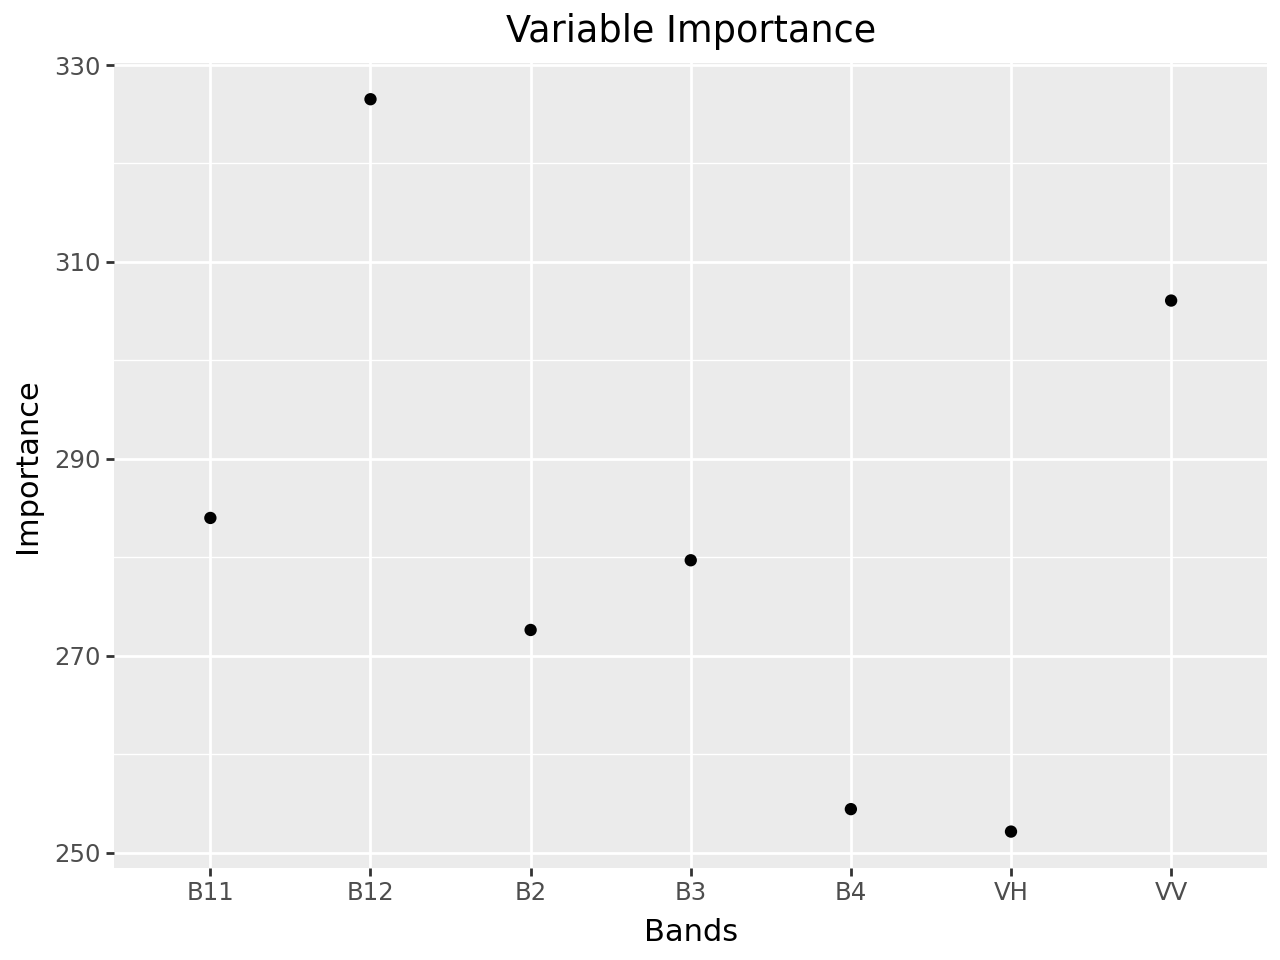

In [83]:
# Create a ggplot point plot with bands on the x and values on the y
(
    ggplot(importance_df, aes(x=bands3, y=values))
    + geom_point()
    + labs(title= 'Variable Importance', x="Bands",y="Importance")
)

# Conclusions
Okay, our model is pretty weak, overall accuracy is at 75%. The model usesmultispectral S2 with S1 VV and VH SAR, from after the Fort Smith fire, to differentiate burned and unburned peatlands and uplands. Considering these are snapshots in time, thats still pretty good. It looks pretty messy though.

To avoid mixing the training and testing data, I used Landsat-based dnbr and Nick's peatland map to define burned areas and peatlands.

Next steps would be to compare these results against a differenced metric such as TCW or TCG or dNDVI. Its still interesting.